In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
from numpy.random import multinomial
from scipy.stats import dirichlet
import matplotlib.tri as tri
from scipy.special import softmax
from matplotlib.lines import Line2D

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
from IPython.core.display import Image, display

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Degree in Data Science and Engineering, group 96
## Machine Learning 2
### Fall 2024

&nbsp;
&nbsp;
&nbsp;
# Lab 4. Unsupervised Learning: Discrete Data

&nbsp;
&nbsp;
&nbsp;

**Jose Manuel de Frutos Porras and David Martínez Rubio**

**Adapted from a notebook by Ignacio Peis**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




# Introduction
In this lab session you will study two probabilistic models for discrete data. First, in Section 1, you will use a Beta-Binomial model for learning the probability of binary data from observations of penalty kicks in the Premier League. Second, in Section 2, you will employ a Dirichlet-Multinomial model for learning the probability that a musical genre appears on a spotify top list. For both cases, we apply simple Bayesian models.

## A few notes on Bayesian modeling
During this notebook, we employ basic probabilistic notation for priors, likelihoods and posteriors. The expression $p(x | y)$ denotes a probability distribution (a mathematical function over the probability for each possible value of $x$) of variable $x$, once $y$ is given. Employing easy terms, we could say that $p(x | y)$ is a function over $x$ that includes a known 'parameter' $y$ inside. In Bayesian world, we use this notation when the probability of a variable $x$ depends on the value of other variable $y$. What if knowing $p(x|y)$, we want to obtain $p(y|x)$? We can use the **Bayes theorem**:
\begin{equation}
p(y|x) = \frac{p(x|y) p(y)}{p(x)}
\end{equation}
We are interested in finding the posterior distribution of a variable. The procedure is always the same:
- First, we assume a model where some parameter $ \theta$ has a role in the generation of data.
- Second, we define a **prior** distribution over the parameter of interest, $p(\theta)$, that captures our a priori assumptions about how $\theta$ might be distributed, and a **likelihood** distribution, $p(\mathcal{D} | \theta)$, that measures how likely your observations given a value of $\theta$ are.
- Third, we compute the **posterior** $p(\theta | \mathcal{D})$ using Bayes theorem. The posterior distribution incorporates knowledge from observed data and gives you a distribution of the parameters, given the **evidence** you have observed in $\mathcal{D}$.
\begin{equation}
p(\theta|\mathcal{D}) = \frac{p(\mathcal{D}|\theta) p(\theta)}{p(\mathcal{D})}
\end{equation}
The denominator is a normalization constant called *evidence*. As it is constant, we will ignore it to compute the posterior distribution, using:
\begin{equation}
p(\theta|\mathcal{D}) \propto p(\mathcal{D}|\theta) p(\theta)
\end{equation}
The posterior distribution will give you the values of $\theta$ that are more likely, given your dataset. Different approaches can be employed to obtain an estimation for the parameter of interest $\hat{\theta}$.


# 1. Binary data
In this first section we use a model for binary data. The parameter $\theta$ is the probability of $1$ (success). Given this parameter, we can express how likely the observations are via the likelihood function. For this section, we are going to model the probability of scoring a goal in soccer penalty kicks.


## 1.1. Dataset
The dataset $\mathcal{D}$ is composed by $N=106$ binary $D$-dimensional observations, in the form:

$\textbf{x}_i = [x_1, ..., x_D] \qquad$ with $x_i \in \{0, 1\}  \qquad \mathcal{D}= \{ \textbf{x}_1, ..., \textbf{x}_N \} \qquad$

We use the following <a href="https://www.kaggle.com/mauryashubham/english-premier-league-penalty-dataset-201617">dataset</a> that contains a register of penalty kicks in Premier League for season 2016/2017. Data is formatted in the csv file <code>penalty_data.csv</code>, and we are going to model variables $x_1$: <code>Scored</code>, $x_2$: <code>Foot</code>, $x_3$: <code>Kick_Direction</code>, $x_4$: <code>Keeper_Direction</code> and $x_5$: <code>Half</code>, for some value of <code>Team</code> and <code>Player</code>. For variable  <code>Scored</code>, $0 \equiv miss$ and $1 \equiv goal$. For variables <code>Foot</code>, <code>Kick_Direction</code> and <code>Keeper_Direction</code>, $0 \equiv left$ and $1 \equiv right$. For variable <code>Half</code>, $0 \equiv first$ and $1 \equiv second$. An example of how to obtain a matrix $\textbf{X}$ with all the observations for team "Man City" and player "Harry Kane" during the season is included below. We employ <a href="https://pandas.pydata.org/docs/reference/index.html#api">pandas</a> for reading the dataset.




In [ ]:
# If you run locally, set use_colab=False
use_colab=False

if use_colab==True:
    # To work in colab
    from google.colab import files
    uploaded = files.upload()
    import io
    data = pd.read_csv(io.BytesIO(uploaded['penalty_dataset.csv']))

else:
    data = pd.read_csv('penalty_dataset.csv')
N = len(data)
variables = ['Scored', 'Foot', 'Kick_Direction', 'Keeper_Direction', 'Half']
D = len(variables)
data.head()


,No.,Match Week,Date,Player,Team,Match,Half,Scored,Final Results,Foot,Kick_Direction,Keeper_Direction,Saved
0,1,1,13-Aug-16,Riyad Mahrez,Leicester,Hull vs Leicester,1,1,42737,0,0,1,NaN
1,2,1,13-Aug-16,Sergio Agüero,Man City,Man City vs Sunderland,0,1,42737,1,0,0,NaN
2,3,1,14-Aug-16,Theo Walcott,Arsenal,Arsenal vs Liverpool,0,0,42828,1,0,0,1.0
3,4,1,15-Aug-16,Eden Hazard,Chelsea,Chelsea vs West Ham,1,1,42737,1,0,0,NaN
4,5,2,19-Aug-16,Zlatan Ibrahimovic,Man United,Man United vs Southampton,1,1,2-0,1,0,1,NaN


In [ ]:

def filter_data(data, key="all", value=""):
    if key=='all':
        X=np.array(data[variables]).astype(int)
    else:
        filtered = data[data[key]==value][variables]
        X = np.array(filtered).astype(int)
    return X

# Penalties for Man City
X = filter_data(data, 'Team', 'Man City')
print("Penalty kicks for Man City: ")
print(str(X))

# Penalties for Harry Kane
X = filter_data(data, 'Player', 'Harry Kane')
print("Penalty kicks for Harry Kane: ")
print(str(X))

# All the penalties
X = filter_data(data, 'all')


Penalty kicks for Man City: 
[[1 1 0 0 0]
 [1 1 0 1 0]
 [1 1 0 1 1]
 [0 1 1 1 0]
 [0 1 0 0 1]
 [1 1 0 1 1]
 [1 1 0 0 1]
 [1 1 0 1 1]
 [1 1 0 1 0]]
Penalty kicks for Harry Kane: 
[[1 1 1 1 1]
 [1 1 0 0 1]
 [1 1 0 1 0]
 [0 1 0 1 1]
 [1 1 1 0 1]
 [1 1 0 0 1]]


## 1.2. Model

### 1.2.1. Likelihood
The likelihood function models how likely the data is given a value of the parameters. The **Bernouilli distribution**, parametrized by $\theta$, models the probability of success in a binary-outcome experiment. This distribution will model each dimension inside each observation. As we assume independent dimensions, the probabilities per dimension are multiplied:

\begin{equation}
p(\mathcal{D} | \theta) = \prod_{i=1}^N \prod_{k=1}^D \text{Ber} (x_{id}| \theta_d) = \prod_{i=1}^N \prod_{i=1}^D \theta_d^{\mathbb{I}(x_{id}=1)} (1-\theta_d)^{\mathbb{I}(x_{id}=0)}
\end{equation}

#### Sufficient Statistics
To make our life easier, we use the sufficient statistics of $\mathcal{D}$. Instead of evaluating whether each variable is scored, we sum the number of successes ($1$) and failures ($0$) in $N$ kicks and use $N_1 = \sum_{i=1}^N \mathbb{I}(x_i=1)$ and $N_0 = \sum_{i=1}^N \mathbb{I}(x_i=0)$. We call $\phi(\mathcal{D})$ sufficient statistics for parameter $\theta$ from $\mathcal{D}$ if $p(\theta | \mathcal{D}) = p(\theta | \phi(\mathcal{D})) $. From this perspective, we use the **Binomial distribution**, which models the number of successes $N_1$ in a total of $N$ trials.
Thus, our equivalent likelihood is:

\begin{equation}
p(\mathcal{D} | \theta) \equiv \prod_{d=1}^{D} p(N_{1d} | \theta_d) = \prod_{d=1}^{D} \text{Bin}(N_{1d}|N, \theta) =
\prod_{d=1}^{D}
\begin{pmatrix}
N  \\ N_{1d}
\end{pmatrix}
\theta^{N_{1d}}(1-\theta_d)^{N_{0d}}
\end{equation}

### 1.2.2. Prior
The prior distribution models the information we know *a priori* about how the parameters are distributed. It will influence the learned posterior. The **Beta distribution** models the probability of a variable with range between $0$ and $1$. Two parameters, $a$ and $b$, control the shape of the distribution:

\begin{equation}
p(\theta) = \text{Beta}(\theta|a, b) = \frac{1}{B(a, b)} \theta^{a-1} (1-\theta)^{b-1}
\end{equation}
where $B(a, b) = \frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)}$ and $\Gamma(\cdot)$ is the Gamma function.

When $a=b$ the function is symmetric. If $a=b>1$ the probability mass will be closer to the center ($\theta=0.5$), while if $a=b<1$ the probability mass will be more concentrated in the corners. If $a=b=1$, the probability is uniform, and all the values of $\theta$ are equiprobable. We will denote this configuration as *flat prior*. Using different values for $a$ and $b$ we can control the asymmetry and assign more or less probability to each class.

In this case, as we have binary vectors, we are defining a different prior for each $\theta_d$, and thus, parameters $a_d$ and $b_d$ need to be defined for each dimension:
\begin{equation}
p(\boldsymbol{\theta}) = \prod_{d=1}^{D} \text{Beta}(\theta_d|a_d, b_d)
\end{equation}

For example, for variable <code>Scored</code> ($d=1$), we expect that probability of goal is higher than miss. Thus, we might choose a value of $a$ higher than $b$. Nevertheless, for the variable <code>Half</code> ($d=5$) (half of the match where the penalty was kicked), we do not know a priori which half is more likely, so $a=b=1$ (flat prior) is adequate for this dimension.

*Note: The scipy.stats beta probability function can be used in this notebook. Use <code>beta.pdf(theta, a, b)</code> to compute the probability density of <code>theta</code> with parameters $a$ and $b$.*



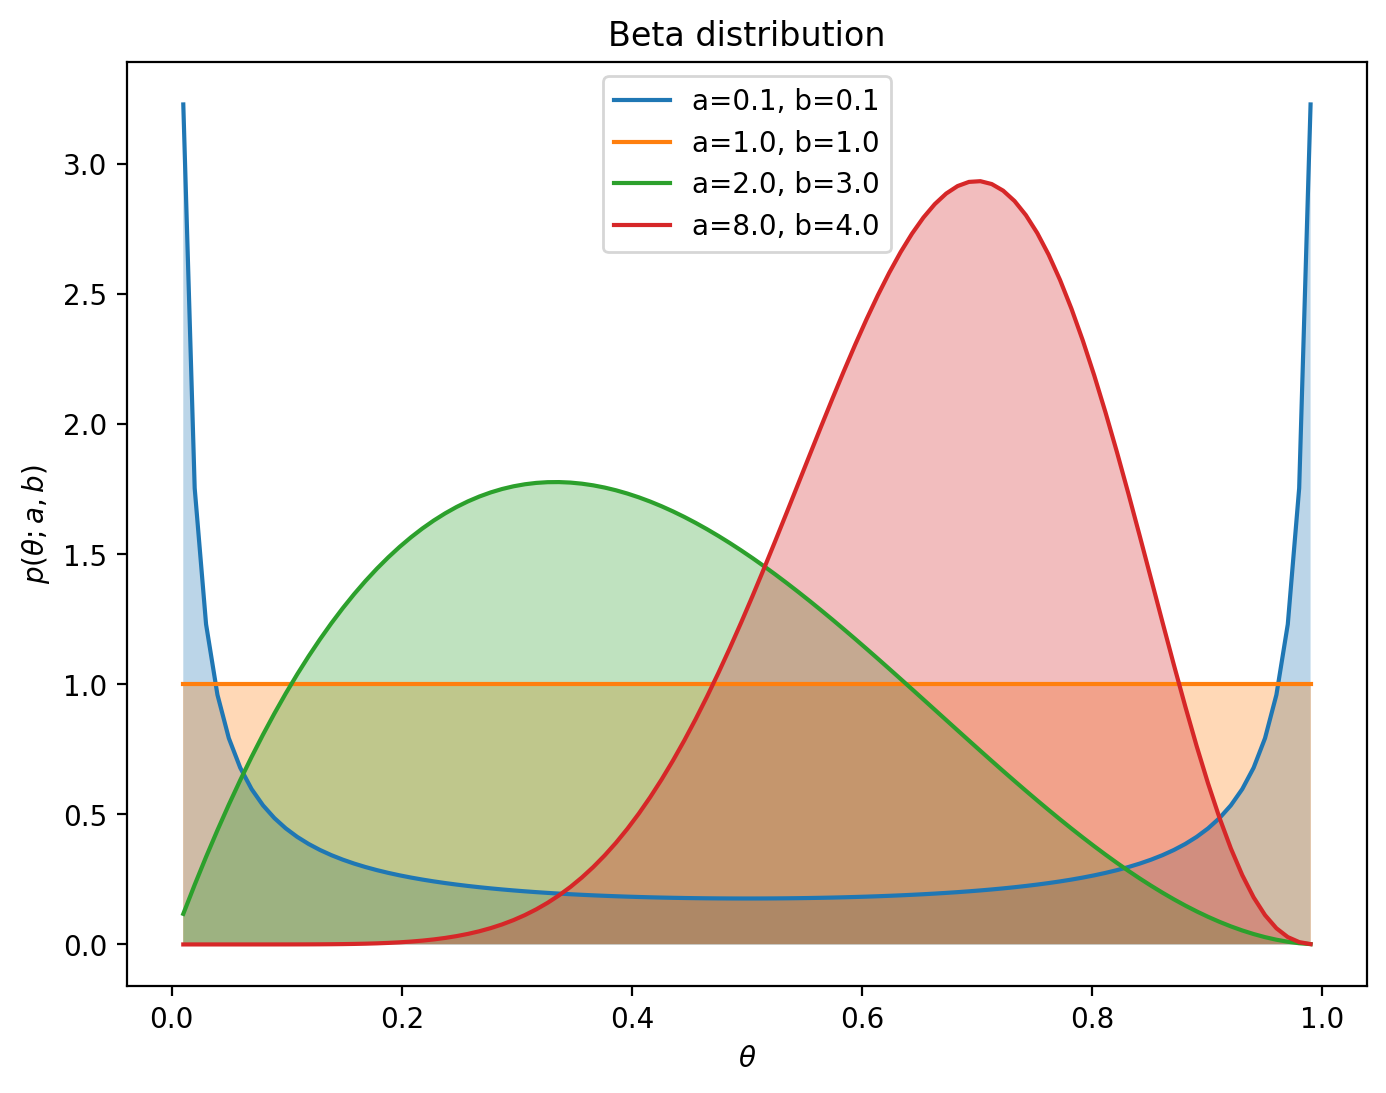

In [ ]:

# Visualizing the beta distribution
a_list = [0.1, 1.0, 2.0, 8.0]        # 4 possible values of a
b_list = [0.1, 1.0, 3.0, 4.0]        # 4 possible values of b
x_domain = np.linspace(0.01, 0.99, 100)    # 100 points beween 0 and 1

plt.figure(figsize=(8, 6))
for a, b in zip(a_list, b_list):
    p = beta.pdf(x_domain, a, b)
    plt.plot(x_domain, p, label='a=' + str(a) + ', b=' + str(b))
    plt.fill_between(x_domain, 0, p, alpha=0.3 )
plt.legend(loc='best')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$ p(\theta; a, b) $')
ttl=plt.title('Beta distribution')


As you can see above, the uniform distribution over $[0, 1]$ is obtained when $a=b=1$ (orange line). With the red distribution we model a parameter that generates more goals than misses. The green one express the contrary, we expect more misses than goals. The width of the distributions gives us an idea of how much the probability mass is concentrated around the maximum.

### 1.2.3. Posterior
The posterior distribution can be obtained from the prior and likelihood, using Bayes Rule:

\begin{gather}
\begin{matrix}
    p(\boldsymbol{\theta} | \mathcal{D}) &  \propto  & p(\mathcal{D} | \boldsymbol{\theta}) p(\boldsymbol{\theta}) \\
    & \propto & \prod_{d=1}^{D} \theta_d^{N_{1d}}(1-\theta_d)^{N_{0d}} \theta_d^{a_d-1} (1-\theta_d)^{b_d-1} \\
    & \propto & \prod_{d=1}^{D} \theta_d^{N_{1d}+a_d-1} (1-\theta_d)^{N_{0d}+b_d-1} \\
    & = & \prod_{d=1}^{D} \text{Beta}(N_{1d}+a_d, N_{0d}+b_d)
\end{matrix}
\end{gather}
The posterior of $\theta$, given the sufficient statistics from the observations in $\mathcal{D}$ and defining the prior as a Beta on each dimension, is another product of Beta distributions with parameters $N_{1d}+a_d$ and $N_{0d} +b_d$ on each dimension. The property of the posterior having the same functional form than the prior (same type of distribution) is called **conjugacy**.

### 1.2.4. Estimation
Once the model is fitted, we can make estimations of the value of $\theta$. As we assume independent dimensions, from the posterior distribution $p(\boldsymbol{\theta} | \mathcal{D})=\prod_{d=1}^{D}p(\theta_d | \mathcal{D})$ we can obtain the estimations $\hat{\theta}_d$ using one of several criteria:
- **Maximum A Posteriori (MAP)**: the estimate is the mode of the posterior $p(\theta_d | \mathcal{D})$.
   
\begin{equation}
    \hat{\theta}_d^{MAP} = \underset{x}{\operatorname{argmax}} p(\theta_d | \mathcal{D}) = \frac{N_{1d}+a_d-1}{N+a_d+b_d-2}
\end{equation}
You can observe that $a_d$ are $b_d$ (user-defined for the prior) influence the posterior results.

- **Maximum Likelihood (ML)**: the estimate is the mode of the likelihood $p( \mathcal{D} | \theta_d)$.
   
\begin{equation}
    \hat{\theta}_d^{ML} = \underset{x}{\operatorname{argmax}} p( \mathcal{D} | \theta) = \frac{N_{1d}}{N}
\end{equation}

- **Mean**: the estimate is the mean of the posterior:
\begin{equation}
    \hat{\theta}_d^{mean} = \bar{\theta_d} = \frac{N_{1d}+a_d}{N+a_d+b_d}
\end{equation}

The variance of the posterior distribution gives us a measure of the variability of the probability of success. The higher the variance, the more uncertainty we have about :
\begin{equation}
    \text{Var}(\theta_d | \mathcal{D}) = \frac{(N_{1d}+a_d)(N_{0d}+b_d)}{(N+a_d+b_d)^2(N+a_d+b_d+1)} \approx \frac{\bar{\theta}_d (1-\bar{\theta}_d)}{N}
\end{equation}

Another important distribution is the **posterior predictive** that gives the probability of a new trial, given all the experience:
\begin{gather}
\begin{matrix}
p(x_d=1|\mathcal{D}) & = & \int_0^1  p(x_d=1 | \theta_d) p(\theta_d | \mathcal{D}) d \theta_d \\
& = & \int_0^1 \theta_d \text{Beta}(N_{1d}+a_d, N_{0d}+b_d) d\theta_d \\
& = & \mathbb{E} \{ \theta_d | \mathcal{D} \} = \bar{\theta}_d = \frac{N_{1d}+a_d}{N+a_d+b_d}
\end{matrix}
\end{gather}


## 1.3. Experiments

### 1.3.1. Sufficient statistics

**Calculate the sufficient statistics $\textbf{N}_0 =[N_{01}, ..., N_{05}]$ and $\textbf{N}_1=[N_{11}, ..., N_{15}]$  of the dataset $\mathcal{D}$.**

In [ ]:
#############
#           #
# YOUR CODE #
#           #
#############
N0 = np.zeros(D, dtype=int)  # Initialize N0 with zeros
N1 = np.zeros(D, dtype=int)  # Initialize N1 with zeros

for d in range(D):  # Iterate through each dimension (variable)
    N1[d] = np.sum(X[:, d])  # Count occurrences of 1 in the current dimension
    N0[d] = X.shape[0] - N1[d]  # Count occurrences of 0 (total - occurrences of 1)

print("N0: ", N0)  # Print N0 values
print("N1: ", N1)  # Print N1 values


N0:  [25 21 67 54 42]
N1:  [81 85 39 52 64]


### 1.3.2. Computing the posterior distribution

**Compute the parameters $\textbf{a}_{\text{post}}$ and $\textbf{b}_{\text{post}}$ of the posterior distribution $p(\boldsymbol{\theta} | \mathcal{D})$, once defined the prior with $\textbf{a}$ and $\textbf{b}$, using the given expressions. Use a flat prior ($a_d=b_d=1$) for every dimension. Show $p(\theta_d | \mathcal{D})$ for $d={1, ..., 5}$ in the same plot.**


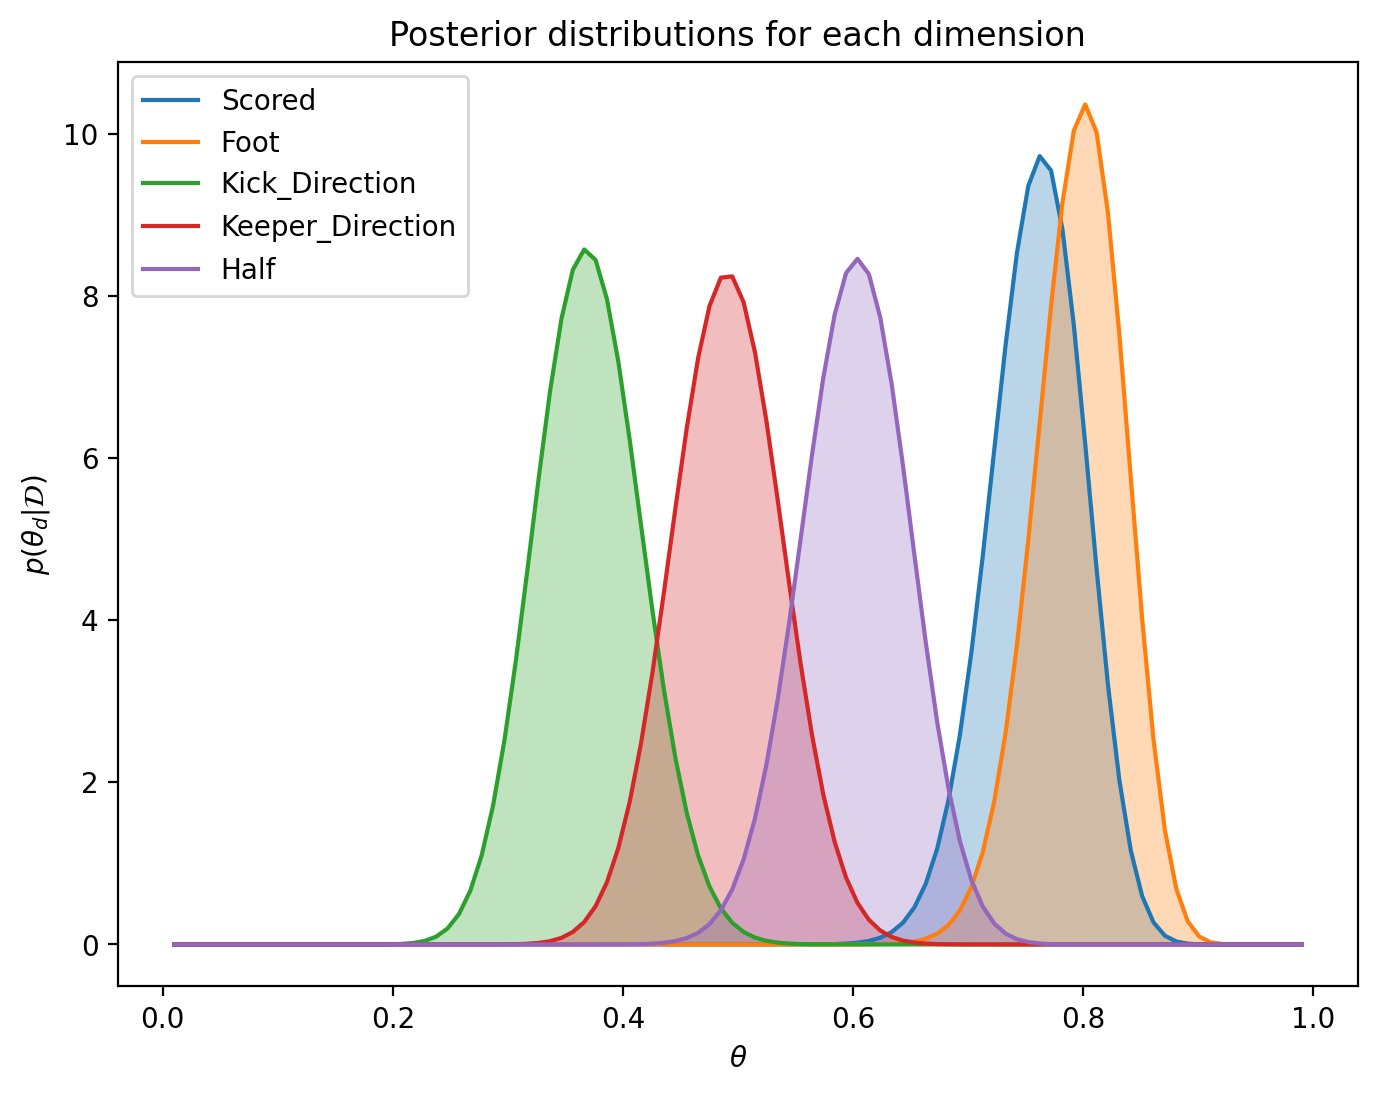

In [ ]:
#############
#           #
# YOUR CODE #
#           #
#############
a_prior = np.ones(D)  # Flat prior for a
b_prior = np.ones(D)  # Flat prior for b

a_post = N1 + a_prior  # Posterior a
b_post = N0 + b_prior  # Posterior b

# Plotting
x_domain = np.linspace(0.01, 0.99, 100)
plt.figure(figsize=(8, 6))

for d in range(D):
    p = beta.pdf(x_domain, a_post[d], b_post[d])
    plt.plot(x_domain, p, label=variables[d])
    plt.fill_between(x_domain, 0, p, alpha=0.3)

plt.legend(loc='best')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta_d | \mathcal{D})$')
plt.title('Posterior distributions for each dimension')
plt.show()

### 1.3.3 Influence of the dataset size
In this section you will evaluate and study the estimation results when varying the dataset size by filtering for different Players and Teams.

**1. Obtain and compare in the same plot the posterior distribution of scoring a goal $p(\theta_0 | \mathcal{D})$ for each player in the given list. Include the prior in the same plot (use flat prior, $a=b=1$).**

**2. Obtain and compare in the same plot the posterior distribution of the kick direction $p(\theta_3 | \mathcal{D})$ for each player in the given list. Include the prior in the same plot (use flat prior, $a=b=1$). In this case, include also the posterior for the entire dataset.**

**3. Obtain and compare in the same plot the posterior distribution of scoring a goal for each team in the given list. Include the prior in the same plot (use flat prior, $a=b=1$).**

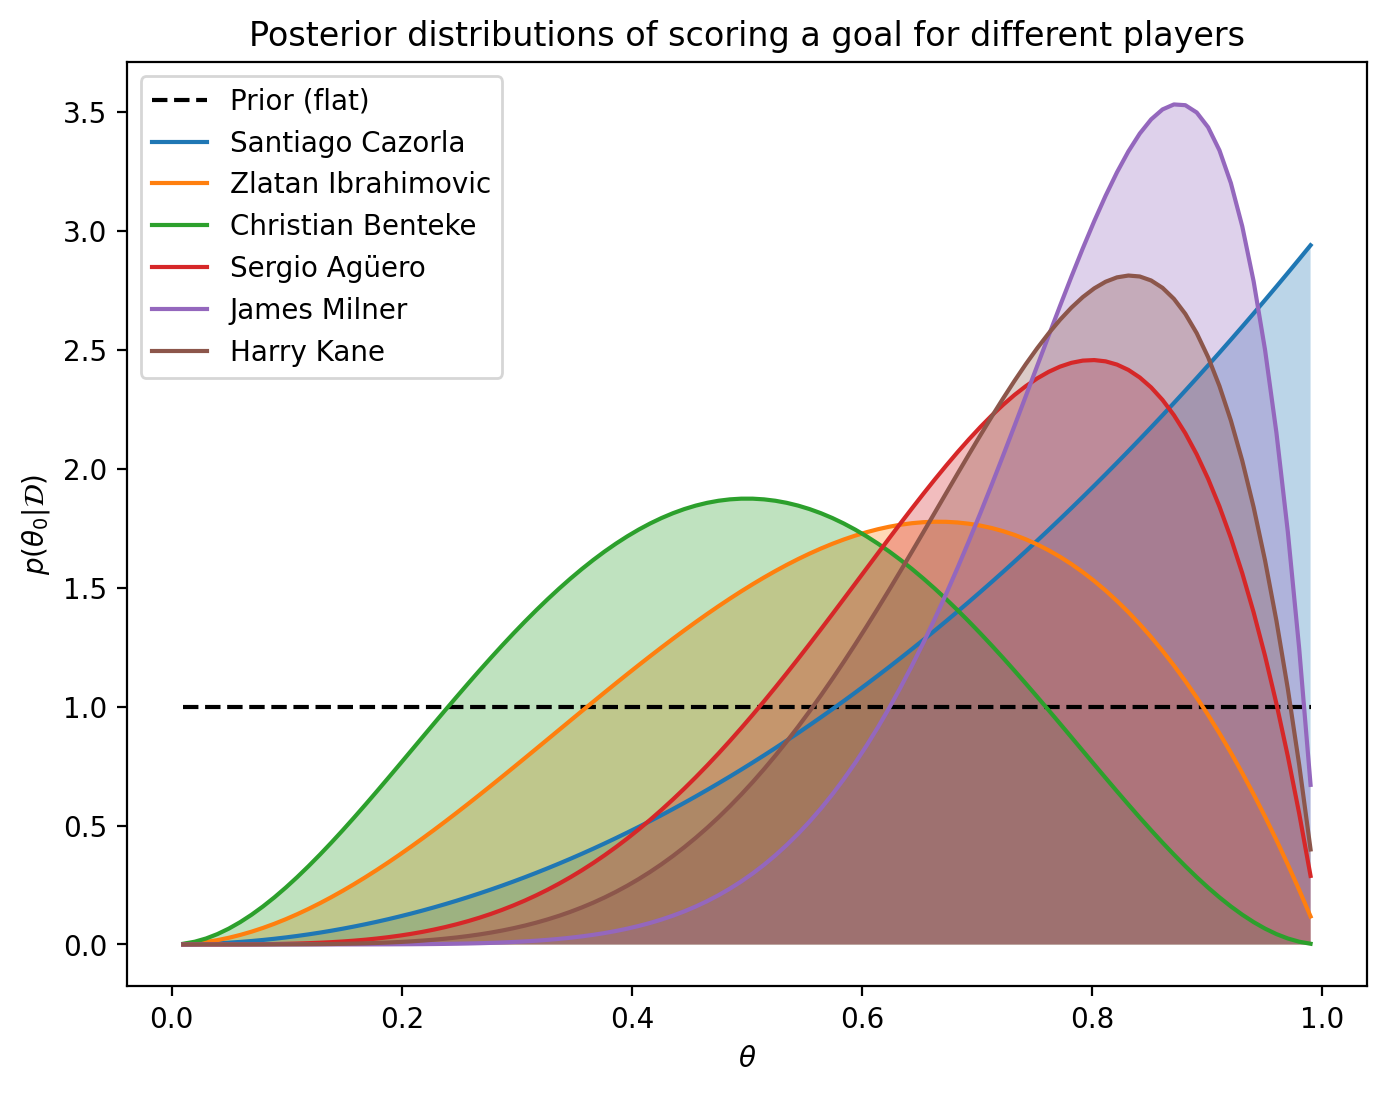

In [ ]:
players = ['Santiago Cazorla', 'Zlatan Ibrahimovic', 'Christian Benteke', 'Sergio Agüero', 'James Milner','Harry Kane']
teams = ['West Brom', 'Middlesbrough', 'Watford', 'Man United', 'West Ham', 'Arsenal', 'Crystal Palace', 'Liverpool', 'Man City']
##########################
#         PLAYERS        #
##########################

# x0: SCORED
d = 0

plt.figure(figsize=(8, 6))

# Prior (flat prior)
a_prior = 1
b_prior = 1
x_domain = np.linspace(0.01, 0.99, 100)
p_prior = beta.pdf(x_domain, a_prior, b_prior)
plt.plot(x_domain, p_prior, label='Prior (flat)', linestyle='--', color='black')

for player in players:
    X_player = filter_data(data, 'Player', player)
    N1_player = np.sum(X_player[:, d])
    N0_player = X_player.shape[0] - N1_player

    a_post = N1_player + a_prior
    b_post = N0_player + b_prior

    p_post = beta.pdf(x_domain, a_post, b_post)
    plt.plot(x_domain, p_post, label=player)
    plt.fill_between(x_domain, 0, p_post, alpha=0.3)

plt.legend(loc='best')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta_0 | \mathcal{D})$')
plt.title('Posterior distributions of scoring a goal for different players')
plt.show()



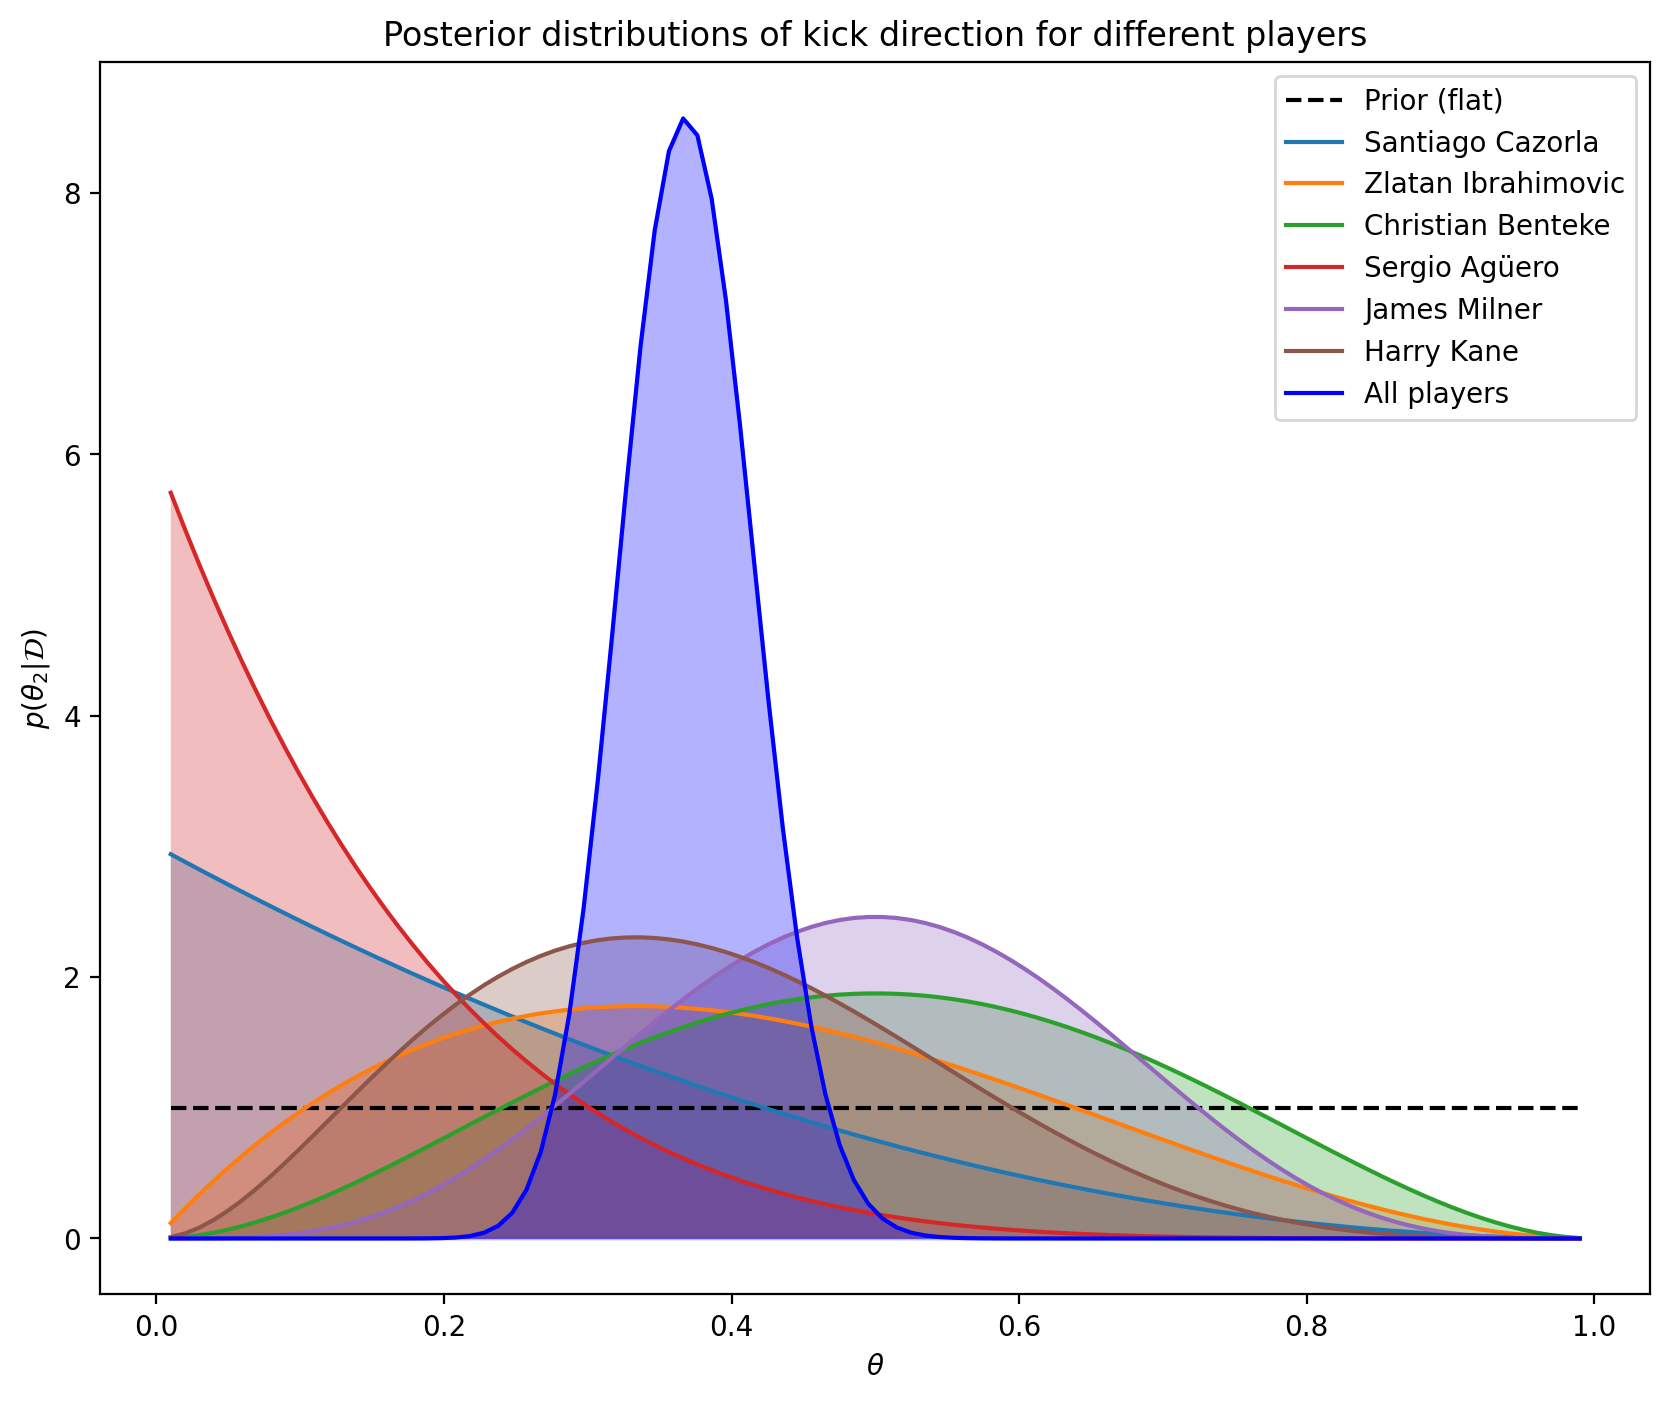

In [ ]:
# Define constants
d = 2  # Column index for KICK_DIRECTION
a_prior = 1
b_prior = 1
x_domain = np.linspace(0.01, 0.99, 100)

# Plot setup
plt.figure(figsize=(10, 8))

# Prior (flat prior)
p_prior = beta.pdf(x_domain, a_prior, b_prior)
plt.plot(x_domain, p_prior, label='Prior (flat)', linestyle='--', color='black')

# Posterior distributions for each player
for player in players:
    X_player = filter_data(data, 'Player', player)
    N1_player = np.sum(X_player[:, d])
    N0_player = X_player.shape[0] - N1_player

    a_post = N1_player + a_prior
    b_post = N0_player + b_prior

    p_post = beta.pdf(x_domain, a_post, b_post)
    plt.plot(x_domain, p_post, label=player)
    plt.fill_between(x_domain, 0, p_post, alpha=0.3)

# Posterior distribution for the entire dataset
X_all = filter_data(data, 'all')
N1_all = np.sum(X_all[:, d])
N0_all = X_all.shape[0] - N1_all

a_post_all = N1_all + a_prior
b_post_all = N0_all + b_prior
p_post_all = beta.pdf(x_domain, a_post_all, b_post_all)
plt.plot(x_domain, p_post_all, label='All players', color='blue')
plt.fill_between(x_domain, 0, p_post_all, alpha=0.3, color='blue')

# Final plot adjustments
plt.legend(loc='best')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta_2 | \mathcal{D})$')
plt.title('Posterior distributions of kick direction for different players')
plt.show()

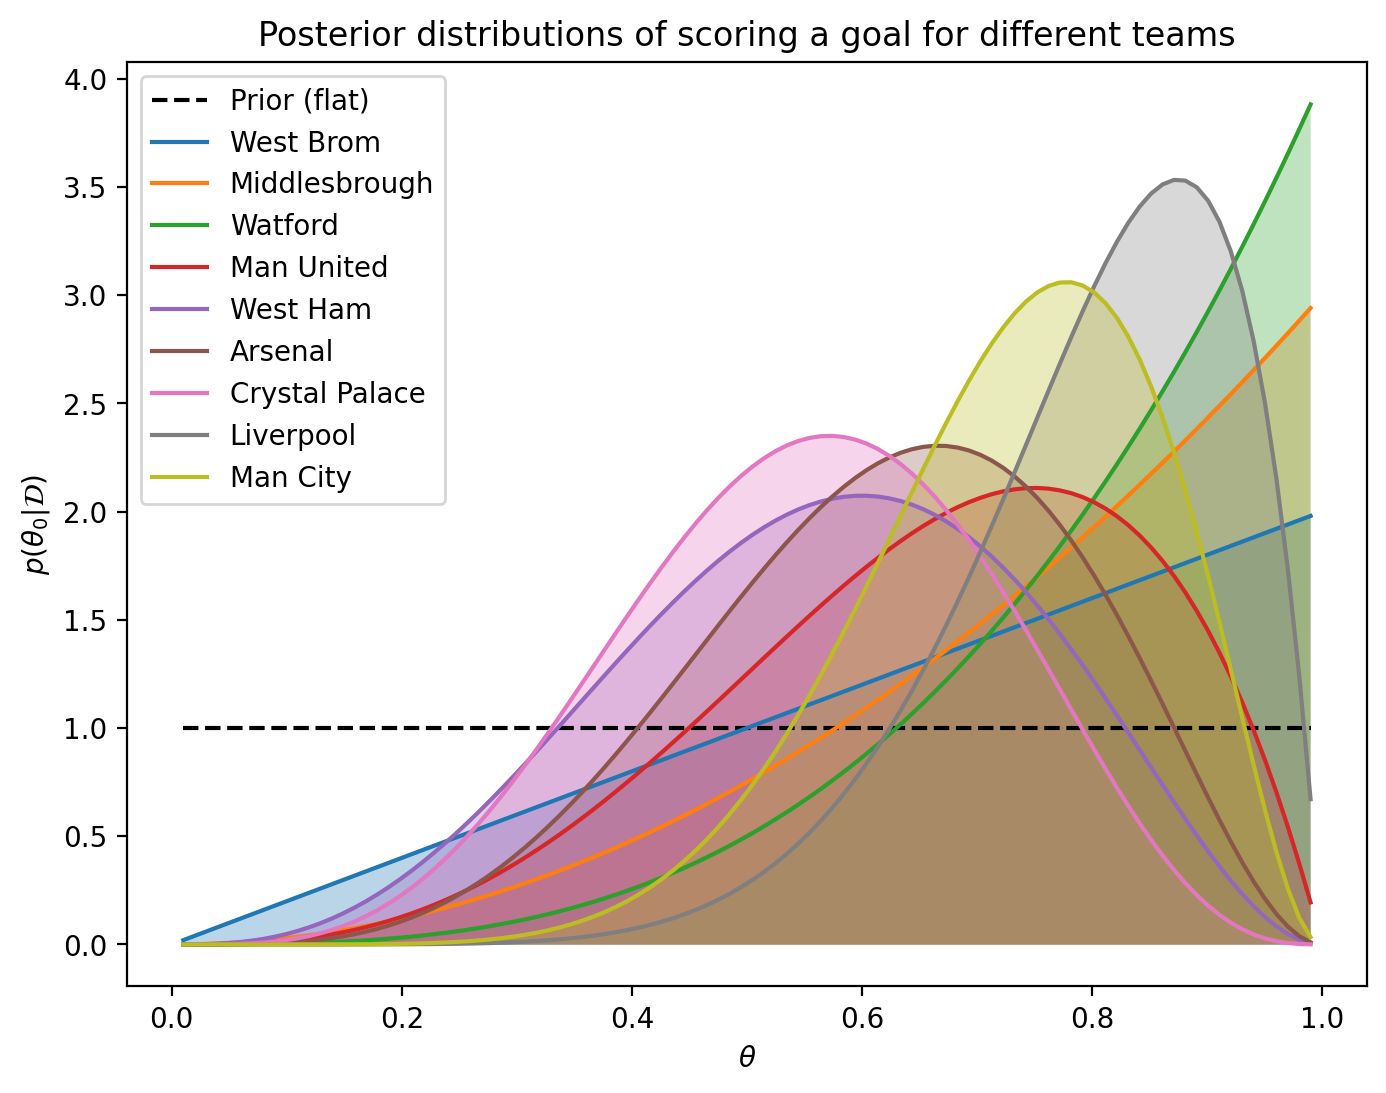

In [ ]:
##########################
#          TEAMS         #
##########################
# x0: SCORED
d = 0

plt.figure(figsize=(8, 6))

# Prior (flat prior)
a_prior = 1
b_prior = 1
x_domain = np.linspace(0.01, 0.99, 100)
p_prior = beta.pdf(x_domain, a_prior, b_prior)
plt.plot(x_domain, p_prior, label='Prior (flat)', linestyle='--', color='black')

for team in teams:
    X_team = filter_data(data, 'Team', team)
    N1_team = np.sum(X_team[:, d])
    N0_team = X_team.shape[0] - N1_team

    a_post = N1_team + a_prior
    b_post = N0_team + b_prior

    p_post = beta.pdf(x_domain, a_post, b_post)
    plt.plot(x_domain, p_post, label=team)
    plt.fill_between(x_domain, 0, p_post, alpha=0.3)

plt.legend(loc='best')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta_0 | \mathcal{D})$')
plt.title('Posterior distributions of scoring a goal for different teams')
plt.show()

### Questions
**Give an answer of the following questions, based on the analysis of the plots you have obtained:**

**1. Which differences do you notice among the obtained posterior distributions of scoring a goal and kick direction for different players? *Pay attention to the number of observations for each player*.**

- Your answer.

**2. Who would you say is the most effective for kicking penalties?.**

- Your answer.


### 1.3.4. Influence of the prior
In this section you will study the influence of the prior in the posterior computation.

**1. Obtain and compare in the same plot the posterior distribution of the kick direction $p(\theta_3 | \mathcal{D})$ for left and right-footed players. Using different linestyles, include the results when using three priors: flat prior, fair prior ($a_d=5, b_d=5$) and uninformative prior ($a_d=b_d=0.5$).**

**2. Obtain the MAP estimations for the probability of kicking to the right in a penalty, for left and right-footed players, using flat prior.**

**3. Obtain the posterior of scoring a goal for player Harry Kane.  Compare in the same plot the posterior for the three mentioned priors. In this case, obtain the MAP and ML estimations for each prior.**

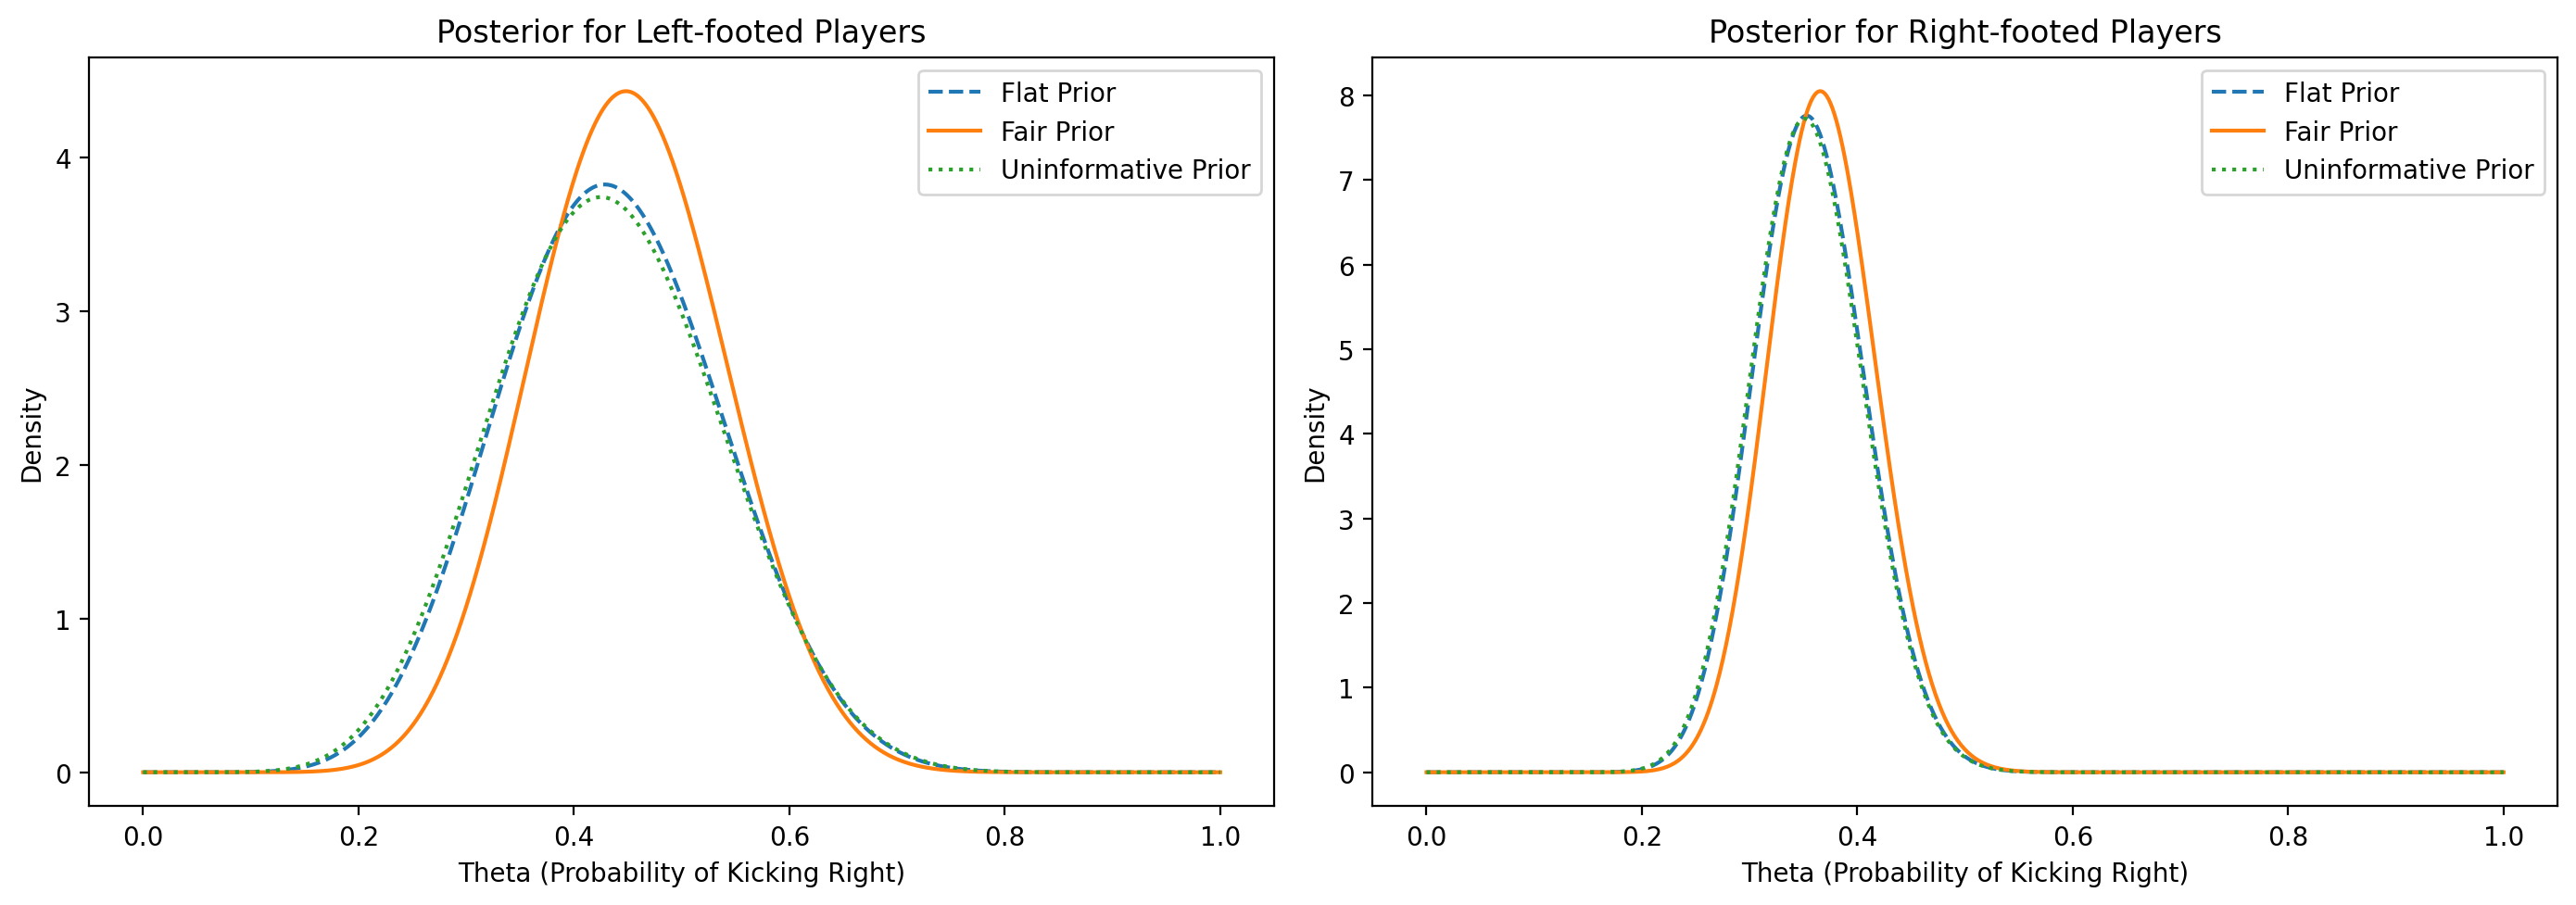

Left-footed Player (Flat Prior): MAP = 0.4286, ML = 0.4286
Right-footed Player (Flat Prior): MAP = 0.3529, ML = 0.3529


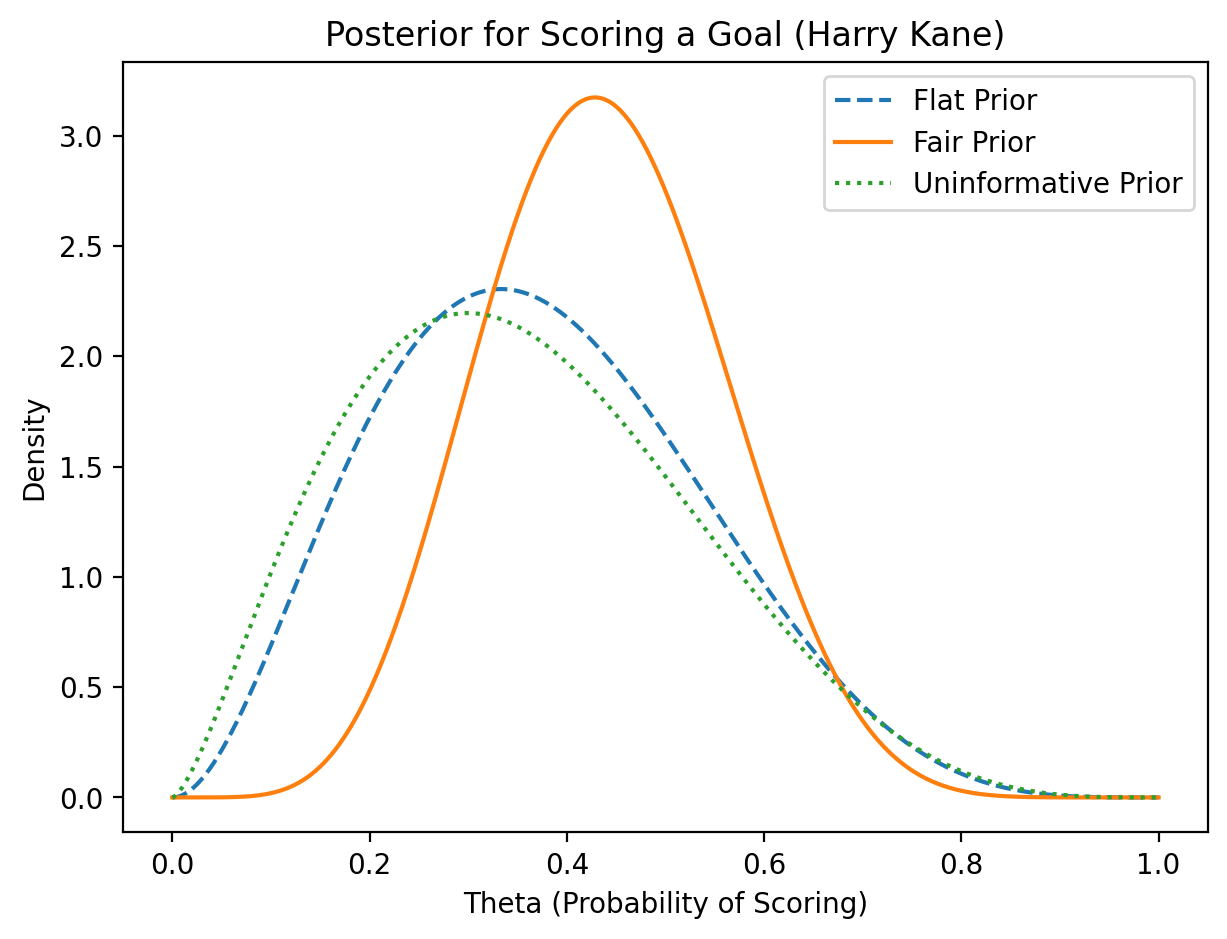

Harry Kane (Flat Prior): MAP = 0.3333, ML = 0.3333
Harry Kane (Fair Prior): MAP = 0.4286, ML = 0.3333
Harry Kane (Uninformative Prior): MAP = 0.3000, ML = 0.3333


In [ ]:
priors = {
    'Flat': (1, 1),
    'Fair': (5, 5),
    'Uninformative': (0.5, 0.5)
}

# Define a function to filter data and convert it to a numpy array
def filter_data(data, key="all", value=""):
    if key == 'all':
        X = np.array(data[variables]).astype(int)
    else:
        filtered = data[data[key] == value][variables]
        X = np.array(filtered).astype(int)
    return X

# Function to compute posterior distribution
def compute_posterior(X, N, a, b):
    theta_values = np.linspace(0, 1, 1000)
    posterior = (theta_values ** (X + a - 1)) * ((1 - theta_values) ** (N - X + b - 1))
    posterior /= np.trapz(posterior, theta_values)  # Normalize the distribution
    return theta_values, posterior

# Function to get MAP estimation
def MAP_est(X, N, a, b):
    return (X + a - 1) / (N + a + b - 2)

# Function to get ML estimation
def ML_est(X, N):
    return X / N

# Filter data for left-footed and right-footed players
X_left = filter_data(data, 'Foot', 0)
X_right = filter_data(data, 'Foot', 1)

# Calculate counts for left and right foot data
N_left = X_left.shape[0]
X_left_count = np.sum(X_left[:, 2])  # Number of kicks to the right for left-footed players

N_right = X_right.shape[0]
X_right_count = np.sum(X_right[:, 2])  # Number of kicks to the right for right-footed players

# Plotting the posteriors for left and right-footed players
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for foot, (X, N, X_count) in zip(['Left-footed', 'Right-footed'], [(X_left, N_left, X_left_count), (X_right, N_right, X_right_count)]):
    for prior_name, (a, b) in priors.items():
        theta_values, posterior = compute_posterior(X_count, N, a, b)
        axes[0 if foot == 'Left-footed' else 1].plot(
            theta_values, posterior, label=f"{prior_name} Prior", linestyle='--' if prior_name == 'Flat' else '-' if prior_name == 'Fair' else ':'
        )

    axes[0 if foot == 'Left-footed' else 1].set_title(f"Posterior for {foot} Players")
    axes[0 if foot == 'Left-footed' else 1].set_xlabel('Theta (Probability of Kicking Right)')
    axes[0 if foot == 'Left-footed' else 1].set_ylabel('Density')
    axes[0 if foot == 'Left-footed' else 1].legend()

plt.tight_layout()
plt.show()

# Calculating MAP and ML estimations for each case
for foot, (X_count, N) in zip(['Left-footed', 'Right-footed'], [(X_left_count, N_left), (X_right_count, N_right)]):
    map_flat = MAP_est(X_count, N, 1, 1)
    ml_est = ML_est(X_count, N)
    print(f"{foot} Player (Flat Prior): MAP = {map_flat:.4f}, ML = {ml_est:.4f}")

# Penalty data for Harry Kane
X_kane = filter_data(data, 'Player', 'Harry Kane')
N_kane = X_kane.shape[0]
X_kane_count = np.sum(X_kane[:, 2])  # Number of kicks to the right for Harry Kane

# Plot posterior for Harry Kane
fig, ax = plt.subplots(figsize=(7, 5))
for prior_name, (a, b) in priors.items():
    theta_values, posterior = compute_posterior(X_kane_count, N_kane, a, b)
    ax.plot(theta_values, posterior, label=f"{prior_name} Prior", linestyle='--' if prior_name == 'Flat' else '-' if prior_name == 'Fair' else ':')

ax.set_title("Posterior for Scoring a Goal (Harry Kane)")
ax.set_xlabel('Theta (Probability of Scoring)')
ax.set_ylabel('Density')
ax.legend()

plt.show()

# Calculating MAP and ML for Harry Kane's case
for prior_name, (a, b) in priors.items():
    map_est = MAP_est(X_kane_count, N_kane, a, b)
    ml_est = ML_est(X_kane_count, N_kane)
    print(f"Harry Kane ({prior_name} Prior): MAP = {map_est:.4f}, ML = {ml_est:.4f}")

In [ ]:
# x0: SCORED
d=0

#############
#           #
# YOUR CODE #
#           #
#############



### Questions

**1. Would you affirm that the prior strongly influences the posterior in the first case? (left/right footed players comparison)**

- Your answer.

**2. If you were a goalkeeper, based on kick direction plot, which direction would you choose to dive, in case you do not know anything about the kicker? (Remember, $0 \equiv left, 1 \equiv right$)**.

- Your answer.

**3. In the posterior for player Harry Kane, does the prior influence the posterior results more or less than in the previous case? Why?**

- Your answer.

**4. Is there any case where MAP and ML estimations are the same? Why?**
- Your answer.

**5. Knowing that Harry Kane is one of the top scorers of the Premier League, which prior would you choose? .**
- Your answer.



# 2. Categorical data
In this seond section we use a model for categorical data. Each observation is one among $K$ categories. The parameter $\boldsymbol{\theta}$ is a vector with the probability of each obtaining each category. For this section, we are going to model the probability of musical genres appearing in the top50 year songs of Spotify.

## 2.1. Dataset

The number of total observations is $N=50$. In this case, $\theta$ is a vector, containing the probabilities for each genre. Observations are categorical, a number between 1 and $K=21$.

$x_i \in \{1, ..., K\}  \qquad \mathcal{D}= \{ x_1, ..., x_N \} \qquad $

We use a <a href="https://www.kaggle.com/leonardopena/top50spotify2019">dataset</a> with the top50 most listened songs of Spotify in 2019. The data is formatted in the file <code>top_spotify_2019.csv</code>, and we are going to model the categorical column <code>"Genre"</code> as $x_i \in \{1, ..., 21\}$.


Number of categories: 21


,Unnamed: 0,Track.Name,Artist.Name,Genre,Beats.Per.Minute,Energy,Danceability,Loudness..dB..,Liveness,Valence.,Length.,Acousticness..,Speechiness.,Popularity
0,1,Señorita,Shawn Mendes,canadian pop,117,55,76,-6,8,75,191,4,3,79
1,2,China,Anuel AA,reggaeton flow,105,81,79,-4,8,61,302,8,9,92
2,3,boyfriend (with Social House),Ariana Grande,dance pop,190,80,40,-4,16,70,186,12,46,85
3,4,Beautiful People (feat. Khalid),Ed Sheeran,pop,93,65,64,-8,8,55,198,12,19,86
4,5,Goodbyes (Feat. Young Thug),Post Malone,dfw rap,150,65,58,-4,11,18,175,45,7,94


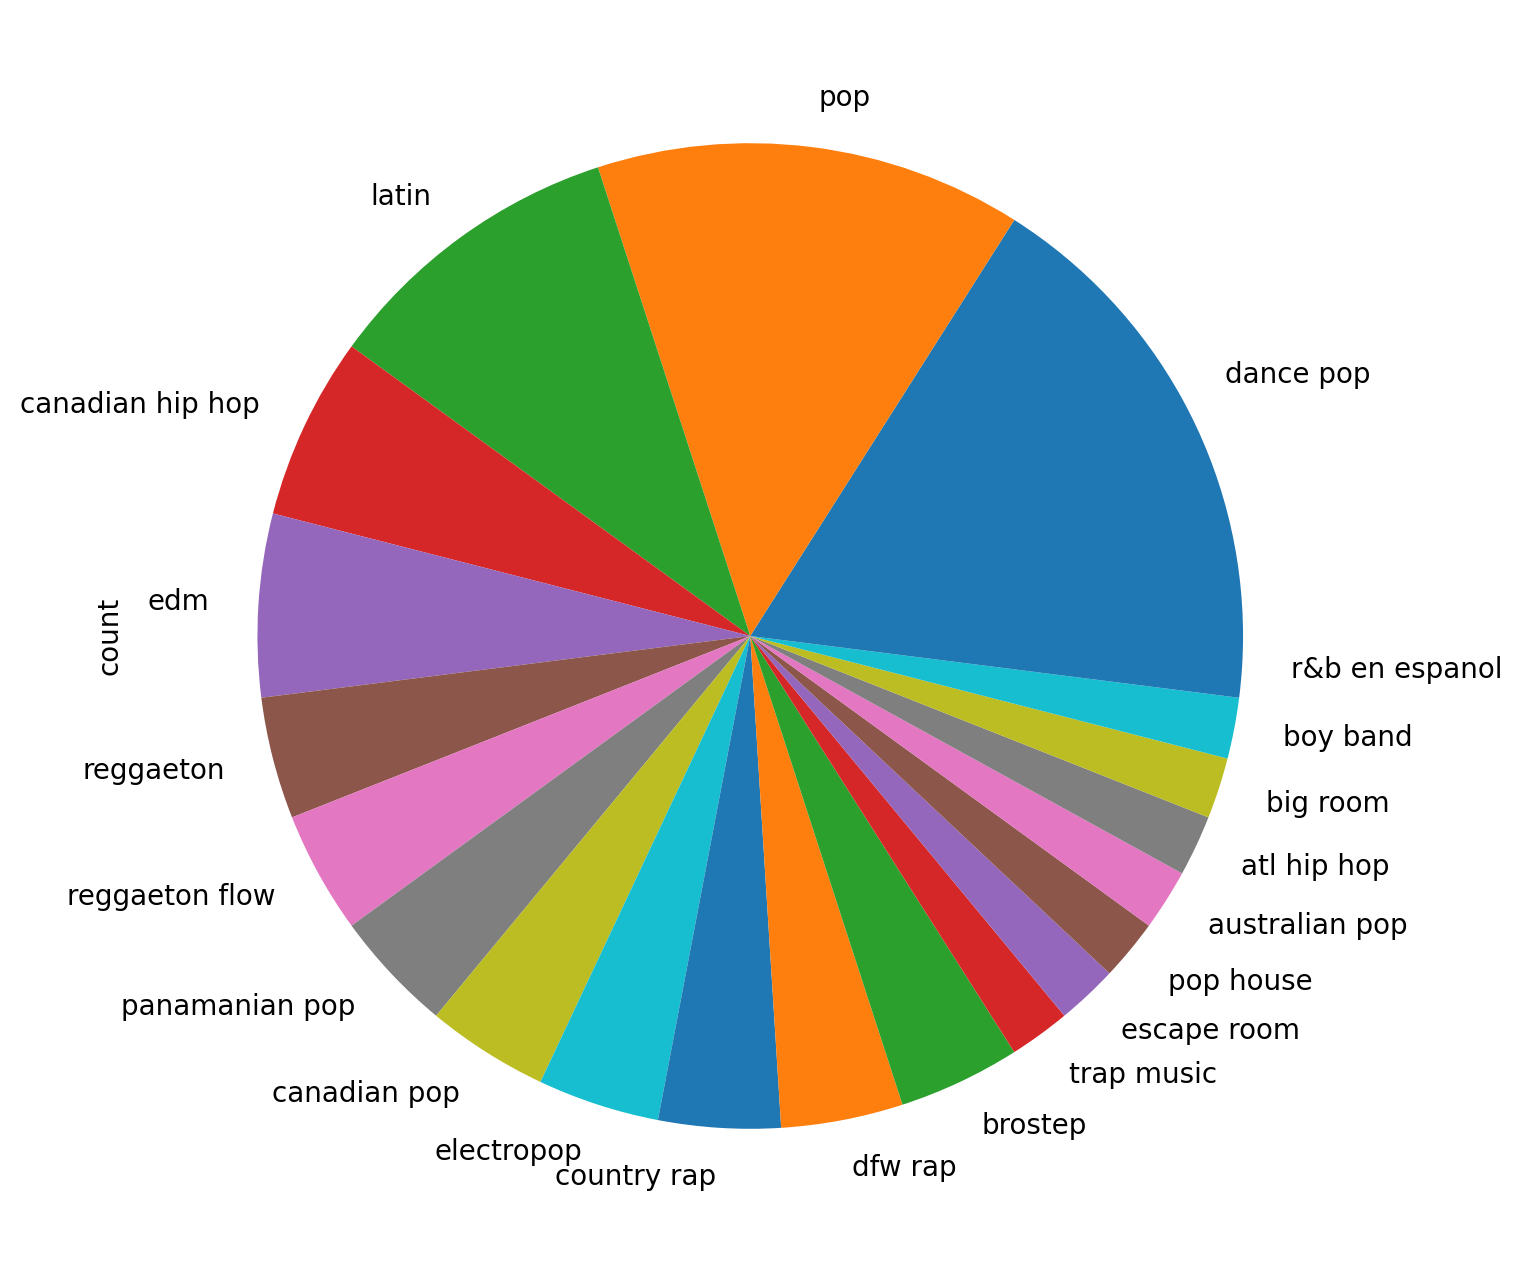

In [ ]:
# If you run locally, set use_colab=False
use_colab=False

if use_colab==True:
    # To work in colab
    from google.colab import files
    uploaded = files.upload()
    import io
    data = pd.read_csv(io.BytesIO(uploaded['top_spotify_19.csv']), encoding='latin1')

else:
    data = pd.load_csvdata = pd.read_csv('top_spotify_19.csv', encoding='latin1')

N = len(data) # N=50

categories = data['Genre'].value_counts().keys().values
D = len(categories)
print("Number of categories: " + str(D))

data['Genre'].value_counts().plot.pie(figsize=(8, 8))
data.head()


## 2.2. Model

### 2.2.1. Likelihood
The likelihood is a **Multinomial distribution**, that models the probability of finding $N_k$ songs for each genre in the top50 list:

\begin{equation}
p(\mathcal{D} | \boldsymbol{\theta}) = \prod_{k=1}^K \theta_k^{N_k} \qquad N_k = \sum_{i=1}^N \mathbb{I} (x_i = k)
\end{equation}

### 2.2.2. Prior
We need a prior for modeling the probabilities $\theta_k$ for $k=\{1, ..., K \}$ that accomplishes $\sum_{k=1}^K\theta_k=1$. The values must sum to $1$. This kind of distribution is called **Dirichlet distribution**, which confines the values of $\theta_k$ to a *simplex* of dimensionality $K-1$. The parameters of the distribution are $\alpha_k$ for $k=\{1, ..., K \}$, that defines the concentration of probability mass for each of the dimensions $k$. If all $\alpha_k$ are $>1$ the mass tends to the center of the simplex, while if all $\alpha_k$ are $< 1$ the mass tends to the corner. At last, if all $\alpha_k$ are $1$ the distribution is flat in the simplex.

\begin{equation}
p(\boldsymbol{\theta}) = \text{Dir}(\boldsymbol{\theta} | \boldsymbol{\alpha}) = \frac{1}{B(\boldsymbol{\alpha})} \prod_{k=1}^K \theta_k^{\alpha_k-1}
\end{equation}
where $B(\boldsymbol{\alpha}) = \frac{\prod_{k=1}^K \Gamma(\alpha_k)}{\Gamma (\alpha_0)}$ and $\alpha_0=\sum_{k=1}^K \alpha_k$.

An example for $K=3$ is included below. First row contains contours of the distribution $p(\boldsymbol{\theta})$, and second row includes samples from this distributions. In the first case (left), as all $\alpha_k$ are nearly 1 but lower, the distribution is nearly uniform, and the mass is more concentrated in the corners, i. e. there are more samples in those locations of the simplex. In the second case (center), all $\alpha_k>1$ and the probability mass is concentrated in the center. In the third case (right) an asymmetric example is included, the peak of probability is close to the first corner ($\alpha_1=2$) and far from the third corner ($\alpha_3=15$).

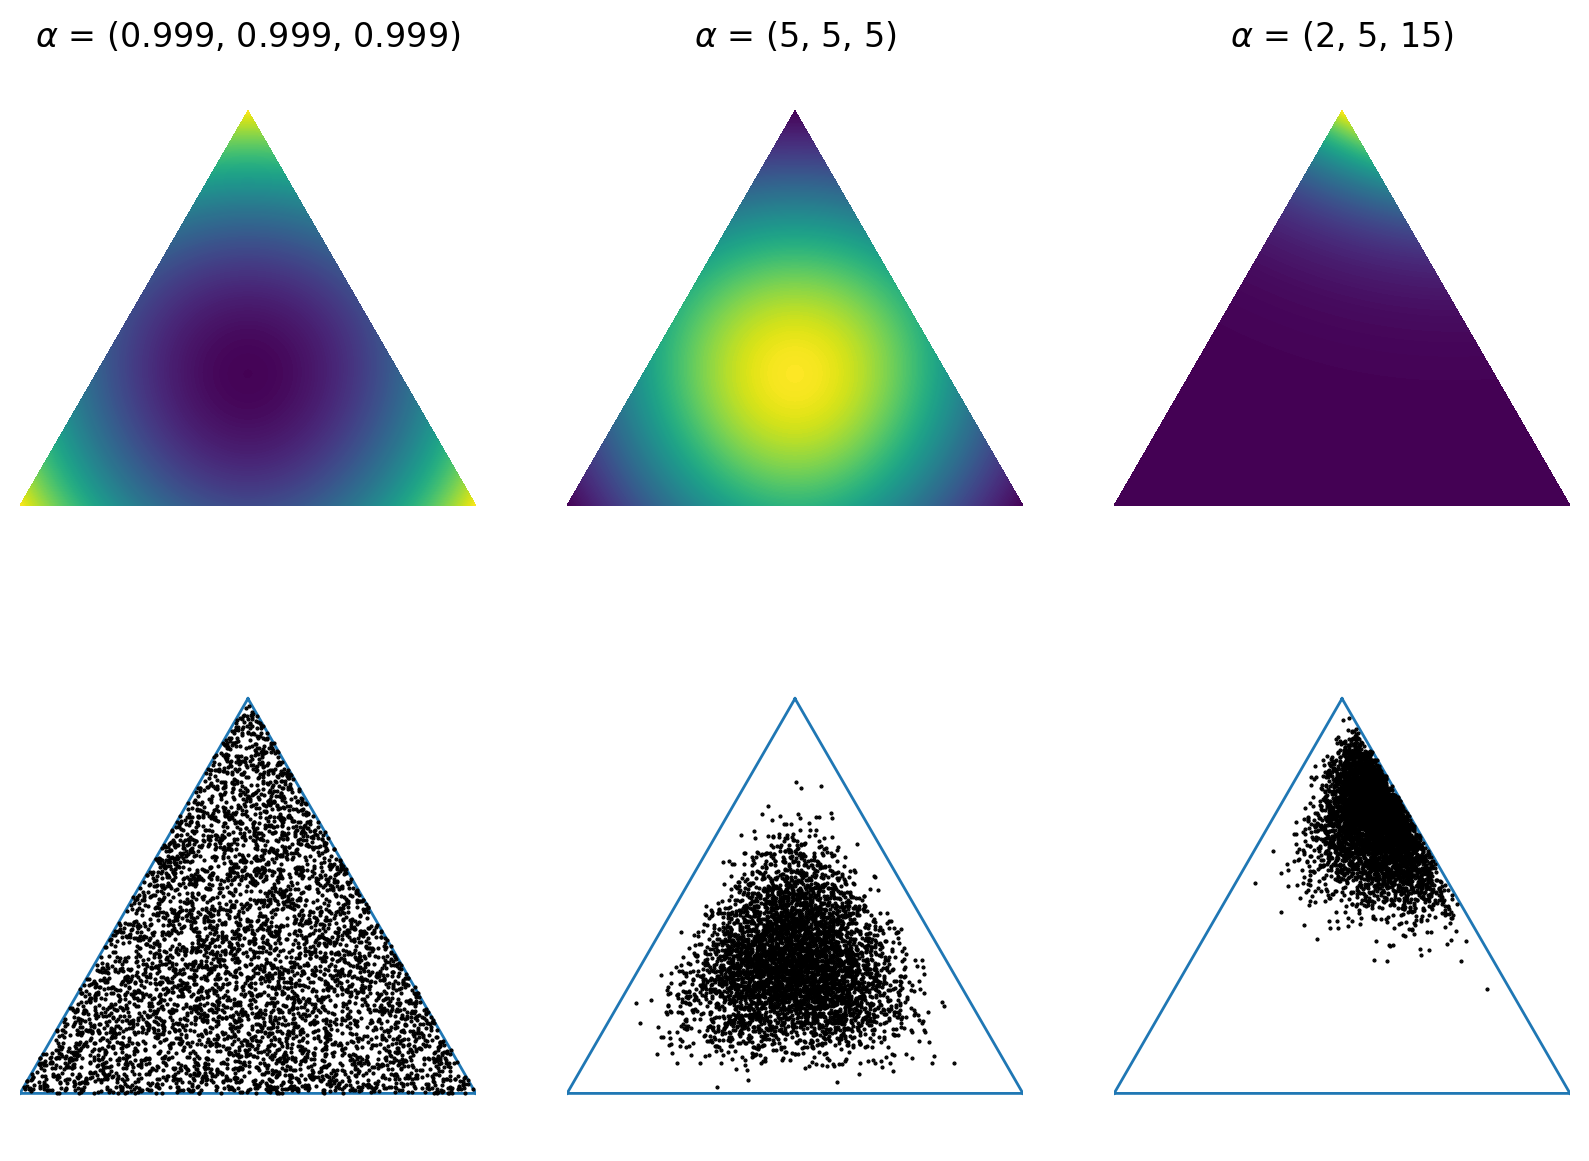

In [ ]:
'''Functions for drawing contours of Dirichlet distributions.'''

_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_AREA = 0.5 * 1 * 0.75**0.5
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])

# For each corner of the triangle, the pair of other corners
_pairs = [_corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))


def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.
    Arguments:
        `xy`: A length-2 sequence containing the x and y value.
    '''
    coords = np.array([tri_area(xy, p) for p in _pairs]) / _AREA
    return softmax(coords)


def dirichlet_simplex(alpha, border=False, nlevels=200, subdiv=8, **kwargs):
    '''Draws pdf contours over an equilateral triangle (2-simplex).
    Arguments:
        `alpha`: Dirichlet parameter vector.
        `border` (bool): If True, the simplex border is drawn.
        `nlevels` (int): Number of contours to draw.
        `subdiv` (int): Number of recursive mesh subdivisions to create.
        kwargs: Keyword args passed on to `plt.triplot`.
    '''
    from matplotlib import ticker, cm
    import math

    refiner = tri.UniformTriRefiner(_triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dirichlet(alpha).pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='viridis', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    if border is True:
        plt.triplot(_triangle, linewidth=1)


def plot_points(X, barycentric=True, border=True, **kwargs):
    '''Plots a set of points in the simplex.
    Arguments:
        `X` (ndarray): A 2xN array (if in Cartesian coords) or 3xN array
                       (if in barycentric coords) of points to plot.
        `barycentric` (bool): Indicates if `X` is in barycentric coords.
        `border` (bool): If True, the simplex border is drawn.
        kwargs: Keyword args passed on to `plt.plot`.
    '''
    if barycentric is True:
        X = X.dot(_corners)
    plt.plot(X[:, 0], X[:, 1], 'k.', ms=1, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    if border is True:
        plt.triplot(_triangle, linewidth=1)


def plot_dirichlet(alphas):
    """Calls to pdf contour and sampling plots.
    `alphas`: LIST of Dirichlet parameter vectors.
    """
    plt.figure(figsize=(10, 7))
    for (i, alpha) in enumerate(alphas):
        plt.subplot(2, len(alphas), i + 1)
        title = r'$\alpha$ = ' + str(tuple(alpha))
        plt.title(title, fontdict={'fontsize': 12})
        dirichlet_simplex(alpha)
        plt.subplot(2, len(alphas), i + 1 + len(alphas))
        plot_points(dirichlet(alpha).rvs(5000))


alphas = [[0.999] * 3,
              [5] * 3,
              [2, 5, 15]]

# For plotting only one distribution:
#alpha=[[5, 5, 5]]

plot_dirichlet(alphas)



### 2.2.3. Posterior
The posterior distribution can be obtained from the prior and likelihood, using Bayes Rule:

\begin{gather}
\begin{matrix}
    p(\boldsymbol{\theta} | \mathcal{D}) &  \propto  & p(\mathcal{D} | \boldsymbol{\theta}) p(\boldsymbol{\theta}) \\
    & \propto & \prod_{k=1}^K \theta_k^{N_k} \theta_k^{\alpha_k-1} = \prod_{k=1}^K \theta_k^{N_k+\alpha_k-1}\\
    & = & \text{Dir}(\boldsymbol{\theta} | \textbf{N} + \boldsymbol{\alpha}) \\
\end{matrix}
\end{gather}
where $\textbf{N}=\{ N_1, ..., N_k\}$ and each $N_i$ equals the number of songs of genre $i$ in the $N=50$ spotify top list.

The posterior of $\boldsymbol{\theta}$, given the sufficient statistics from the observations in $\mathcal{D}$ and defining the prior as a Dirichlet, is another Dirichlet distribution with parameters $\textbf{N} + \boldsymbol{\alpha}$. This is another example of conjugate prior.

### 2.2.4. Estimation
In this example, the estimators have the following expressions:
- **Maximum A Posteriori (MAP)**:.
   
\begin{equation}
    \hat{\theta}_k^{MAP} = \frac{N_k+\alpha_k-1}{N+\alpha_0-K}
\end{equation}

- **Maximum Likelihood (ML)**:
   
\begin{equation}
    \hat{\theta}_{ML} = \underset{x}{\operatorname{argmax}} p( \mathcal{D} | \theta) = \frac{N_1}{N}
\end{equation}

The **posterior predictive** that gives the probability of song $x$ from genre $k$ in a new top list is:
\begin{gather}
p(x=k | \mathcal{D}) = \frac{N_k+\alpha_k}{N+\alpha_0}
\end{gather}

## 2.3. Experiments

### 2.3.1. Computing the posterior distribution

Compute the $\boldsymbol{\alpha}$ parameters of the posterior distribution. Use a flat prior.


Genre Counts:
 Genre
dance pop           8
pop                 7
latin               5
canadian hip hop    3
edm                 3
reggaeton           2
reggaeton flow      2
panamanian pop      2
canadian pop        2
electropop          2
country rap         2
dfw rap             2
brostep             2
trap music          1
escape room         1
pop house           1
australian pop      1
atl hip hop         1
big room            1
boy band            1
r&b en espanol      1
Name: count, dtype: int64
Posterior Alpha Parameters: [9. 8. 6. 4. 4. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2.]
Top 3 Genres: Index(['dance pop', 'pop', 'latin'], dtype='object', name='Genre')
Posterior Alpha Parameters for Top 3 Genres: [9. 8. 6.]


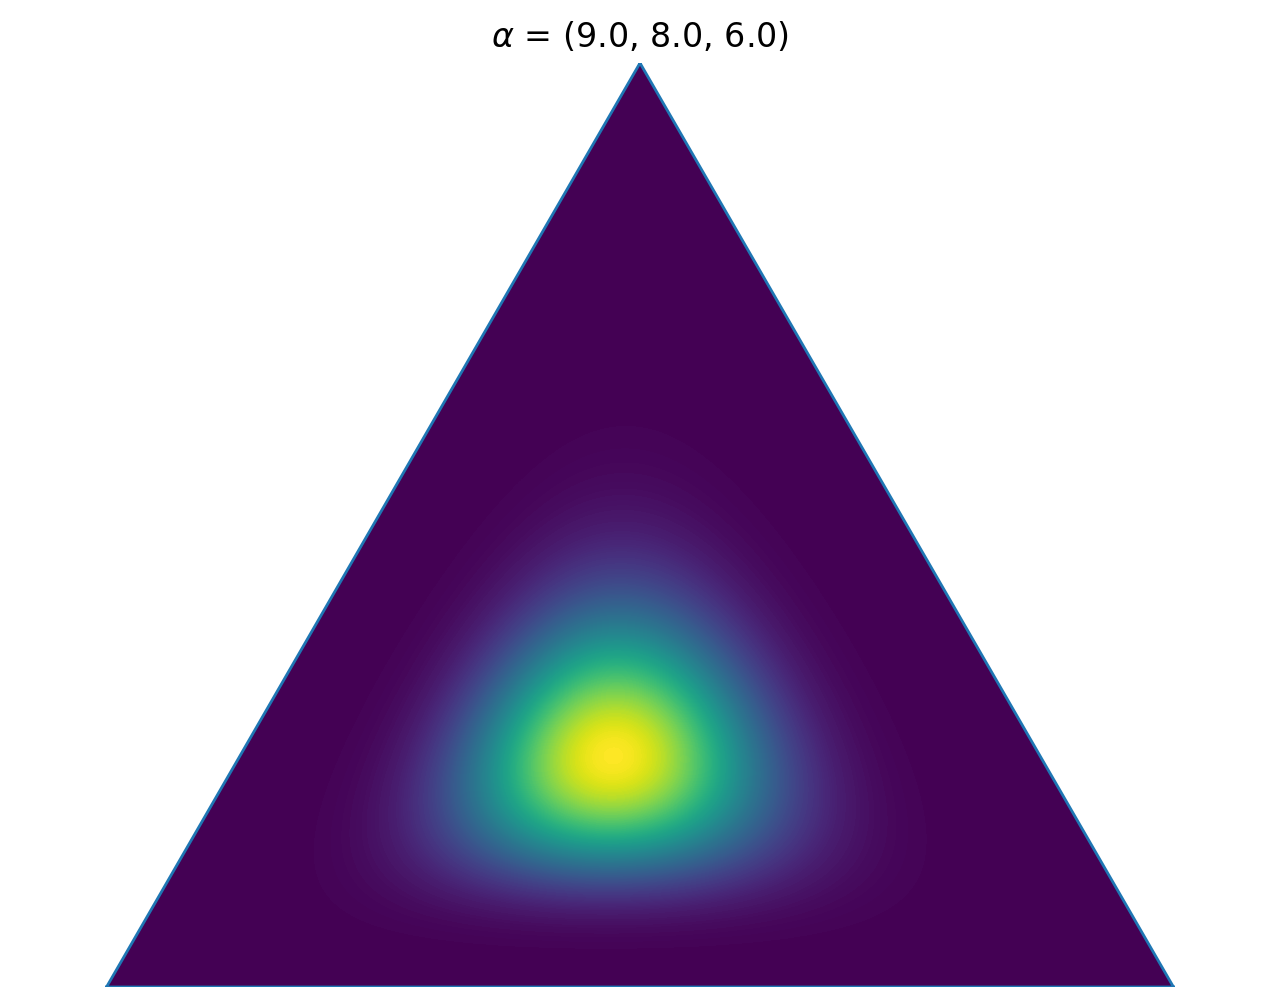

MAP Estimations for Top 3 Genres: [0.4  0.35 0.25]
ML Estimations for Top 3 Genres: [0.4  0.35 0.25]


In [ ]:
# Step 1: Count the number of songs for each genre
genre_counts = data['Genre'].value_counts()
print("Genre Counts:\n", genre_counts)

# Step 2: Set the total number of genres (K)
K = len(genre_counts)

# Step 3: Set the flat prior (alpha = 1 for each genre)
alpha_flat = np.ones(K)

# Step 4: Compute the posterior parameters: N + alpha
N = genre_counts.values
alpha_posterior = N + alpha_flat

print("Posterior Alpha Parameters:", alpha_posterior)

# Step 5: Select the top 3 genres for visualization
top_genres = genre_counts.index[:3]
alpha_posterior_top = alpha_posterior[:3]

print("Top 3 Genres:", top_genres)
print("Posterior Alpha Parameters for Top 3 Genres:", alpha_posterior_top)

# Function to draw Dirichlet PDF contours
def dirichlet_simplex(alpha, border=False, nlevels=200, subdiv=8, **kwargs):
    '''Draws pdf contours over an equilateral triangle (2-simplex).'''
    from matplotlib import tri, ticker, cm

    # Define an equilateral triangle
    _corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    _AREA = 0.5 * 1 * 0.75**0.5
    _triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])

    # For each corner of the triangle, the pair of other corners
    _pairs = [_corners[np.roll(range(3), -i)[1:]] for i in range(3)]
    # The area of the triangle formed by point xy and another pair of points
    tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

    def xy2bc(xy, tol=1.e-4):
        '''Converts 2D Cartesian coordinates to barycentric.'''
        coords = np.array([tri_area(xy, p) for p in _pairs]) / _AREA
        return coords / coords.sum()

    refiner = tri.UniformTriRefiner(_triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dirichlet(alpha).pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='viridis', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    if border:
        plt.triplot(_triangle, linewidth=1)

# Step 6: Plot the Dirichlet distribution for the top 3 genres
def plot_dirichlet_distribution(alpha_params):
    """Plots the Dirichlet distribution for the given alpha parameters."""
    plt.figure(figsize=(8, 6))
    dirichlet_simplex(alpha_params, border=True)
    plt.title(r'$\alpha$ = ' + str(tuple(alpha_params)), fontdict={'fontsize': 12})
    plt.show()

plot_dirichlet_distribution(alpha_posterior_top)

# Step 7: Calculate MAP and ML estimations for the top 3 genres
theta_map = (N[:3] + alpha_flat[:3] - 1) / (np.sum(N[:3]) + np.sum(alpha_flat[:3]) - 3)
theta_ml = N[:3] / np.sum(N[:3])

print("MAP Estimations for Top 3 Genres:", theta_map)
print("ML Estimations for Top 3 Genres:", theta_ml)

### 2.3.2. Parameter estimation

Obtain the MAP estimator for parameters $\hat{\theta}_k$ for all the genres. Plot a pie chart with these probabilities, using <code>pd.Series(data=theta_map, index=categories, name='MAP estimates').plot.pie()</code>.


Genre Counts:
 Genre
dance pop           8
pop                 7
latin               5
canadian hip hop    3
edm                 3
reggaeton           2
reggaeton flow      2
panamanian pop      2
canadian pop        2
electropop          2
country rap         2
dfw rap             2
brostep             2
trap music          1
escape room         1
pop house           1
australian pop      1
atl hip hop         1
big room            1
boy band            1
r&b en espanol      1
Name: count, dtype: int64
MAP Estimates for All Genres: [0.16 0.14 0.1  0.06 0.06 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02]


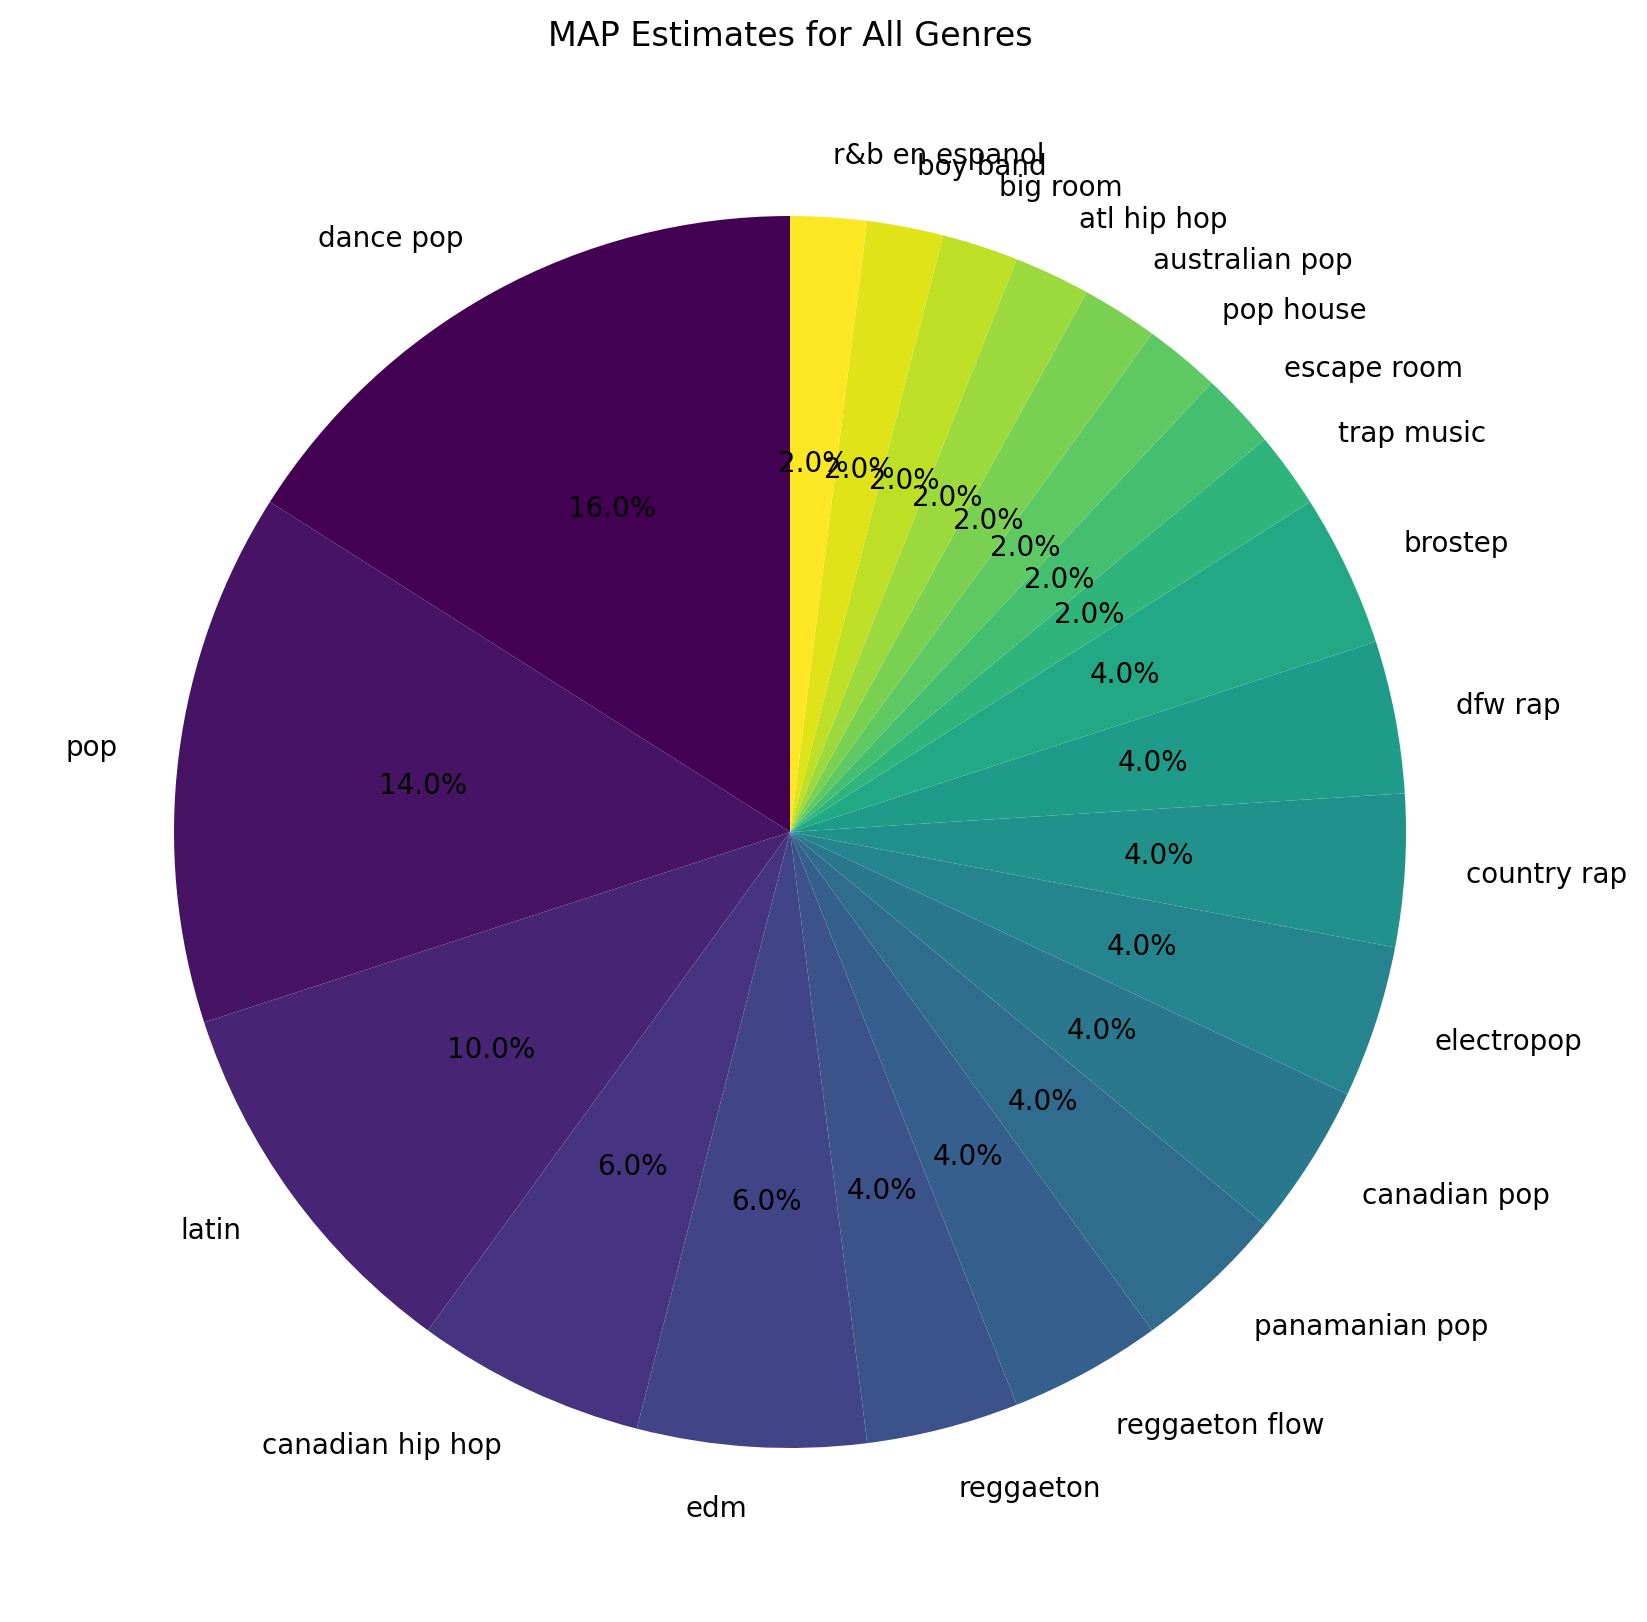

In [ ]:
# Count the number of songs for each genre
genre_counts = data['Genre'].value_counts()
print("Genre Counts:\n", genre_counts)

# Total number of genres (K)
K = len(genre_counts)

# Set the flat prior (alpha = 1 for each genre)
alpha_flat = np.ones(K)

# Compute the total number of observations
N = genre_counts.sum()

# Function to compute the MAP estimation
def dirichlet_MAP_est(Nk, N, alpha):
    """MAP estimation of theta, given counts Nk, trials N and Dirichlet prior parameters alpha."""
    theta_map = (Nk + alpha - 1) / (N + np.sum(alpha) - K)
    return theta_map

# Get MAP estimates for all genres
Nk = genre_counts.values
theta_map = dirichlet_MAP_est(Nk, N, alpha_flat)

# Print the MAP estimates
categories = genre_counts.index
print("MAP Estimates for All Genres:", theta_map)

# Plot the MAP estimates as a pie chart
pd.Series(data=theta_map, index=categories, name='MAP estimates').plot.pie(
    autopct='%1.1f%%', figsize=(10, 10), startangle=90, colormap='viridis'
)
plt.title('MAP Estimates for All Genres')
plt.ylabel('')  # Hide y-label for aesthetics
plt.show()

## Questions

**1. Which is the probability that in year 2020, and given 2019 data, a "dance pop" song appear in the top50 of Spotify?**.

- Your answer.

**2. Would you appreciate big differences between pie chart of genre proportions and MAP estimations? Why? *Hint: first pie is equivalent to another estimator*.**

- Your answer.


## References

[1]. Murphy, K. P. (2012). Machine learning: a probabilistic perspective. MIT press.

[2]. Bishop, C. M. (2006). Pattern recognition and machine learning. springer.

